In [ ]:
# Core libraries
# - numpy / pandas: data handling and quick array ops
# - torch: model, tensors and training utilities
# - matplotlib: plotting results and animations
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from pathlib import Path


In [ ]:
class TB2D(Dataset):
    # A small Dataset wrapper for the 2D three-body data.
    # Input X contains states at time t, Y contains states at time t+1 (next step positions).
    # We store mean/std of X for later denormalization when computing physics-based losses.
    def __init__(self, arr):
        # arr: full data array read from CSV. We treat consecutive rows as timesteps.
        self.X = arr[:-1]
        # target is the next-step positions (first 6 values: 3 bodies × 2 coords)
        self.Y = arr[1:, :6]

        # compute mean/std for normalization (small eps added later when converting to tensors)
        self.mean = self.X.mean(0)
        self.std  = self.X.std(0) + 1e-8

        # normalized inputs (float32 for PyTorch)
        self.Xn = (self.X - self.mean) / self.std

    def __len__(self):
        return len(self.Xn)

    def __getitem__(self, i):
        # return normalized input and raw target (both float32)
        return (
            self.Xn[i].astype(np.float32),
            self.Y[i].astype(np.float32)
        )


In [ ]:
class MLP(nn.Module):
    """
    Simple fully-connected network mapping the 18-d normalized state to 6-d next-step positions.
    - Input dim: 18 (r:6, v:6, a:6 flattened)
    - Output dim: 6 (positions of 3 bodies in 2D)
    """
    def __init__(self, w=256, depth=4):
        super().__init__()
        layers = []
        d = 18
        for _ in range(depth):
            layers += [nn.Linear(d,w), nn.GELU()]
            d = w
        layers += [nn.Linear(d,6)]
        self.f = nn.Sequential(*layers)

    def forward(self,x):
        return self.f(x)


def gravity(r, m, G=1.0, eps=1e-6):
    """
    Compute gravitational acceleration for each body in 2D.
    - r: tensor shape [B, 6] (flattened 3 × 2 positions)
    - m: tensor shape [3] masses
    Returns: accelerations with shape [B, 6]

    The function is vectorized: we reshape to [B,3,2] and compute pairwise differences.
    eps prevents division by zero when bodies get extremely close.
    """
    B = r.shape[0]
    r = r.view(B,3,2)
    a = torch.zeros_like(r)
    for i in range(3):
        # treat body i as the source, compute vector from i to all bodies
        ri = r[:,i:i+1,:]
        d = r - ri
        d2 = (d*d).sum(-1) + eps
        inv = d2.pow(-1.5).unsqueeze(-1)  # inverse distance^3 for vectorized multiplication
        c = d * inv * m.view(1,3,1)
        c[:,i,:] = 0  # no self-interaction
        a[:,i,:] = G * c.sum(1)
    return a.view(B,6)


In [ ]:
# Path to the CSV dataset and time-step used for kinematic loss
csv_path = "modified_TBP_dataset.csv"
dt = 0.01

# read CSV into numpy array
df = pd.read_csv(csv_path)
arr = df.values.astype(np.float64)

# create dataset wrapper which normalizes inputs internally
ds = TB2D(arr)
n = len(ds)
train_n = int(0.9*n)
idx = np.random.permutation(n)
train_idx, val_idx = idx[:train_n], idx[train_n:]

# small Dataset wrapper to index into the Subsets by shuffled indices
class Sub(Dataset):
    def __init__(self, base, ids): self.b=base; self.ids=ids
    def __len__(self): return len(self.ids)
    def __getitem__(self,i): return self.b[self.ids[i]]

# DataLoaders for training and validation (batching/shuffling)
train_loader = DataLoader(Sub(ds,train_idx),batch_size=256,shuffle=True)
val_loader   = DataLoader(Sub(ds,val_idx),batch_size=256,shuffle=False)


In [ ]:
# choose device: use GPU if available for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# net: maps normalized state -> next-step positions
net = MLP().to(device)
opt = torch.optim.AdamW(net.parameters(), lr=1e-3)

# masses and normalization stats moved to device for physics computations
m = torch.tensor([1.,1.,1.],dtype=torch.float32,device=device)
mean = torch.tensor(ds.mean,dtype=torch.float32,device=device)
std = torch.tensor(ds.std,dtype=torch.float32,device=device)

# training loop: compute three losses per batch
for epoch in range(100):  # change to 200 later
    net.train()
    tr = []
    for xb, yb in train_loader:
        # xb is normalized input, yb is next-step true positions
        xb = xb.to(device); yb = yb.to(device)

        # denormalize xb to recover physical r, v, a used for physics/kinematic losses
        den = xb*std + mean
        # split denormalized state into positions (r), velocities (v), accelerations (a)
        r = den[:,:6].view(-1,3,2)
        v = den[:,6:12].view(-1,3,2)
        a = den[:,12:18].view(-1,3,2)

        # forward pass: network predicts next-step positions (in normalized space)
        pred = net(xb)

        # primary data loss: MSE between predicted and true next-step positions
        loss_data = nn.functional.mse_loss(pred, yb)

        # kinematic loss: encourage predicted positions to match simple kinematic integrator
        # r_kin = r + v*dt + 0.5*a*dt^2  (predicted next positions from current state)
        r_kin = r + v*dt + 0.5*a*(dt*dt)
        loss_kin = nn.functional.mse_loss(pred.view(-1,3,2), r_kin)

        # physics loss: compare accelerations from denormalized state to gravity acceleration
        a_new = gravity(r,m)
        # a is the denormalized acceleration from the dataset; compare shapes with a_new
        loss_phys = nn.functional.mse_loss(a.view_as(a_new), a_new)

        # combine losses with small weighting for physics term
        loss = 1.0*loss_data + 1.0*loss_kin + 0.1*loss_phys

        opt.zero_grad()
        loss.backward()
        # clip gradients for stability when using large networks/learning rates
        nn.utils.clip_grad_norm_(net.parameters(),1.0)
        opt.step()

        tr.append(loss.item())

    # validation: compute average data loss on held-out set
    net.eval()
    with torch.no_grad():
        val = []
        for xb,yb in val_loader:
            xb = xb.to(device); yb = yb.to(device)
            pred = net(xb)
            val.append(nn.functional.mse_loss(pred,yb).item())

    print(epoch, np.mean(tr), np.mean(val))


0 50044.00200211164 0.003874390938645586
1 50043.97836371609 0.0038817245528087628
2 50043.97632694451 0.0030539837166996876
3 50043.97818137197 0.003264521398996015
4 50043.99711625069 0.0031956537298279365
5 50043.98116416848 0.0029697316926350233
6 50043.98513345571 0.0028906075155932355
7 50043.97553121247 0.0032973419122375273
8 50043.97732273107 0.0029899307552030156
9 50044.395926918725 0.002992280957861738
10 50044.85011198693 0.003691203275765709
11 50043.98458590156 0.0038562959695444504
12 50043.97958604259 0.0030550001193727595
13 50043.98093107473 0.003253576810733127
14 50043.977973122564 0.0031500925378286806
15 50043.98362241619 0.00388256531766118
16 50043.977178007226 0.003051631162529621
17 50044.06871635902 0.0033220017979861192
18 50044.45839904174 0.0029442908529735876
19 50043.97756197516 0.0034246945366932704
20 50043.98414774985 0.002958700416231221
21 50043.97958676702 0.0030595200149181045
22 50043.9760551483 0.0030780902607729682
23 50043.97871274548 0.00325

In [ ]:
# Predict next positions for first 2000 samples using true inputs (not doing a rollout here)
# We run inference with torch.no_grad() to avoid tracking gradients and reduce memory usage
with torch.no_grad():
    X = ds.Xn[:2000]  # normalized true input states
    X = torch.tensor(X, dtype=torch.float32, device=device)
    # move predictions back to CPU and reshape for plotting: [2000, 3, 2]
    pred_direct = net(X).cpu().numpy().reshape(-1,3,2)


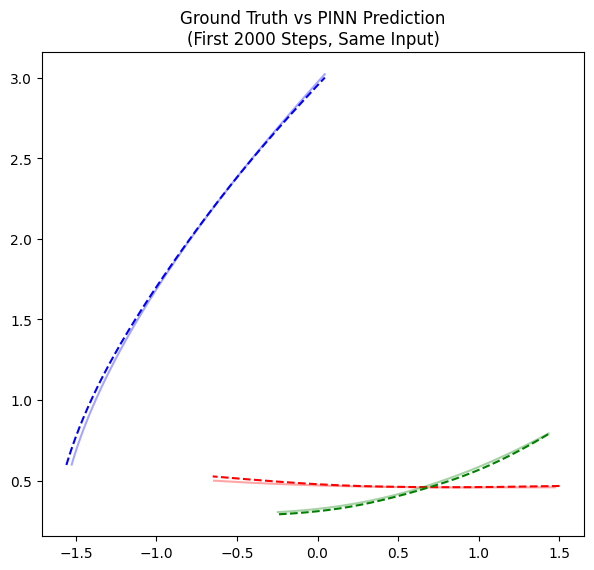

In [ ]:
# Overlay true vs predicted trajectories on one plot for quick visual check
# true_pos: first 2000 true positions (3 bodies × 2 coords), pred_direct: model predictions
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# read raw CSV to get ground-truth positions for plotting
df = pd.read_csv("modified_TBP_dataset.csv")
arr = df.values.astype(np.float64)
true_pos = arr[:2000, :6].reshape(-1,3,2)

colors = ['r','g','b']
plt.figure(figsize=(7,7))

for b in range(3):
    # plot ground truth trajectory (faded) and model prediction (dashed)
    plt.plot(true_pos[:,b,0], true_pos[:,b,1], color=colors[b], alpha=0.35)
    plt.plot(pred_direct[:,b,0], pred_direct[:,b,1], color=colors[b], linestyle='--')

# keep equal aspect ratio so orbits are not distorted
plt.gca().set_aspect("equal","box")
plt.title("Ground Truth vs PINN Prediction\n(First 2000 Steps, Same Input)")
plt.show()


In [ ]:
# save model and stats
# checkpoint includes model weights and normalization stats so you can reload and run predictions later
ckpt = {
    "model_state": net.state_dict(),
    "mean": ds.mean,
    "std": ds.std,
    "dt": dt,
}
torch.save(ckpt, "pinn_2d_model.pt")
print("model saved to pinn_2d_model.pt")


model saved to pinn_2d_model.pt


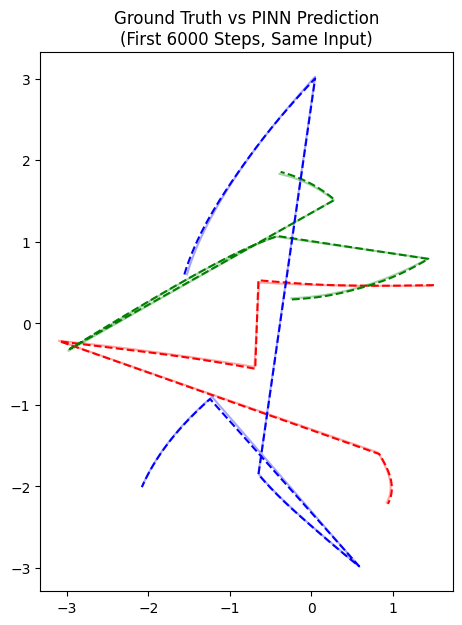

In [16]:
with torch.no_grad():
    X = ds.Xn[:6000]  # normalized true input states
    X = torch.tensor(X, dtype=torch.float32, device=device)
    # move predictions back to CPU and reshape for plotting: [2000, 3, 2]
    pred_direct = net(X).cpu().numpy().reshape(-1,3,2)


# Overlay true vs predicted trajectories on one plot for quick visual check
# true_pos: first 2000 true positions (3 bodies × 2 coords), pred_direct: model predictions
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# read raw CSV to get ground-truth positions for plotting
df = pd.read_csv("modified_TBP_dataset.csv")
arr = df.values.astype(np.float64)
true_pos = arr[:6000, :6].reshape(-1,3,2)

colors = ['r','g','b']
plt.figure(figsize=(7,7))

for b in range(3):
    # plot ground truth trajectory (faded) and model prediction (dashed)
    plt.plot(true_pos[:,b,0], true_pos[:,b,1], color=colors[b], alpha=0.35)
    plt.plot(pred_direct[:,b,0], pred_direct[:,b,1], color=colors[b], linestyle='--')

# keep equal aspect ratio so orbits are not distorted
plt.gca().set_aspect("equal","box")
plt.title("Ground Truth vs PINN Prediction\n(First 6000 Steps, Same Input)")
plt.show()